<a href="https://colab.research.google.com/github/HarshJ803/shiny-octo-parakeet/blob/main/Research_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1. Introduce the data
print("="*50)
print("DATASET INTRODUCTION")
print("="*50)
print(
    "• Source: Yahoo Finance via yfinance Python library\n"
    "• Companies: Apple (AAPL), Microsoft (MSFT), Amazon (AMZN), Google (GOOGL), Tesla (TSLA)\n"
    "• Time Span: 2019-01-01 to 2024-01-01\n"
    "• Features: Date, Open, High, Low, Close, Adj Close, Volume, Ticker"
)

# Load data
file_path = '/content/drive/MyDrive/tech-stock-2019-2024 - tech-stock-2019-2024.csv'
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

#Concise summary stats table
concise_stats = df[numeric_cols + ['Ticker']].groupby('Ticker').agg(['mean', 'std', 'min', 'max']).round(2)
print("\nConcise summary stats for each Ticker:")
display(concise_stats)

#Data normalization and standardization
scaler_std = StandardScaler()
scaler_minmax = MinMaxScaler()
for col in numeric_cols:
    df[f'{col}_z'] = scaler_std.fit_transform(df[[col]])
    df[f'{col}_mm'] = scaler_minmax.fit_transform(df[[col]])

# 4. Line plot of Close price vs. Date for each Ticker (z-score)
plt.figure(figsize=(12, 6))
for ticker in df['Ticker'].unique():
    subset = df[df['Ticker'] == ticker]
    plt.plot(subset['Date'], subset['Close_z'], label=ticker)
plt.title("Standardized (z-score) Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Standardized Close Price")
plt.legend()
plt.show()

#Boxplots for Close price by Ticker (z-score)
plt.figure(figsize=(8, 5))
sns.boxplot(x='Ticker', y='Close_z', data=df, palette='Set2')
plt.title("Standardized Close Price by Ticker")
plt.ylabel("Standardized Close Price (z-score)")
plt.show()

# chart: mean/median volume by Ticker (normalized)
mean_vol = df.groupby('Ticker')['Volume_mm'].mean()
median_vol = df.groupby('Ticker')['Volume_mm'].median()
plt.figure(figsize=(8, 5))
mean_vol.plot(kind='bar', color='skyblue', width=0.4, position=1, label='Mean')
median_vol.plot(kind='bar', color='navy', width=0.4, position=0, alpha=0.5, label='Median')
plt.title("Normalized (0-1) Mean and Median Volume by Ticker")
plt.ylabel("Normalized Volume")
plt.legend()
plt.show()

#Heatmap of correlations (standardized)
zscore_cols = [f"{col}_z" for col in numeric_cols]
plt.figure(figsize=(8,6))
corr = df[zscore_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Standardized Features)")
plt.show()

#Histogram of daily returns (standardized per ticker)
for ticker in df['Ticker'].unique():
    subset = df[df['Ticker'] == ticker].copy()
    subset['Return'] = (subset['Close'] - subset['Open']) / subset['Open']
    subset['Return_z'] = (subset['Return'] - subset['Return'].mean()) / subset['Return'].std()
    plt.figure(figsize=(7,4))
    sns.histplot(subset['Return_z'], bins=30, kde=True, color='C0')
    plt.title(f"Standardized Daily Return Histogram: {ticker}")
    plt.xlabel("Standardized Daily Return (z-score)")
    plt.show()

# Table of record highs/lows by Ticker
records = []
for ticker in df['Ticker'].unique():
    dft = df[df['Ticker'] == ticker]
    high_row = dft.loc[dft['Close'].idxmax()]
    low_row = dft.loc[dft['Close'].idxmin()]
    records.append([
        ticker,
        high_row['Date'].strftime("%Y-%m-%d"),
        round(high_row['Close'],2),
        low_row['Date'].strftime("%Y-%m-%d"),
        round(low_row['Close'],2)
    ])

records_df = pd.DataFrame(records, columns=['Ticker', 'Record High Date', 'Record High Close',
                                            'Record Low Date', 'Record Low Close'])
print("Record High and Low Close Price for Each Ticker:")
display(records_df)

#Ticker vs Record High Close (bar plot)
plt.figure(figsize=(8,4))
sns.barplot(x='Ticker', y='Record High Close', data=records_df, color='gold')
plt.title("Record High Close Price per Ticker")
plt.ylabel("Record High Close ($)")
plt.xlabel("Ticker")
plt.show()

# 11. Record High Date vs Record High Close (scatter plot)
records_df['Record High Date'] = pd.to_datetime(records_df['Record High Date'])
plt.figure(figsize=(8,5))
sns.scatterplot(
    x='Record High Date',
    y='Record High Close',
    data=records_df,
    hue='Ticker',
    s=150
)
for i, row in records_df.iterrows():
    plt.text(row['Record High Date'], row['Record High Close']+5, row['Ticker'], fontsize=10, ha='center')
plt.title("When Did Each Stock Hit Its Record High Close?")
plt.xlabel("Date of Record High")
plt.ylabel("Record High Close ($)")
plt.show()

# 12. Low-to-High Timeline Plot for Each Ticker
plt.figure(figsize=(10,6))
for i, row in records_df.iterrows():
    plt.plot([pd.to_datetime(row['Record Low Date']), row['Record High Date']],
             [row['Record Low Close'], row['Record High Close']],
             marker='o', label=row['Ticker'])
    plt.text(pd.to_datetime(row['Record Low Date']), row['Record Low Close']-5, f"{row['Ticker']} Low", ha='center', fontsize=9)
    plt.text(row['Record High Date'], row['Record High Close']+5, f"{row['Ticker']} High", ha='center', fontsize=9)
plt.title("Record Low to High Trajectory for Each Stock")
plt.xlabel("Date")
plt.ylabel("Close Price ($)")
plt.legend()
plt.tight_layout()
plt.show()

#FacetGrid for Highs and Lows: Each Company's Close Series
df['is_high'] = False
df['is_low'] = False
for i, row in records_df.iterrows():
    df.loc[(df['Ticker']==row['Ticker']) & (df['Close']==row['Record High Close']), 'is_high'] = True
    df.loc[(df['Ticker']==row['Ticker']) & (df['Close']==row['Record Low Close']), 'is_low'] = True

g = sns.FacetGrid(df, col='Ticker', col_wrap=3, height=3.5, aspect=1.4, sharey=False)
g.map_dataframe(sns.lineplot, x='Date', y='Close')
g.map_dataframe(sns.scatterplot, x='Date', y='Close', hue='is_high', size='is_high',
                sizes={False: 0, True: 200}, palette={True: 'red', False: 'none'}, legend=False)
g.map_dataframe(sns.scatterplot, x='Date', y='Close', hue='is_low', size='is_low',
                sizes={False: 0, True: 200}, palette={True: 'blue', False: 'none'}, legend=False)
g.set_titles("{col_name}")
g.set_axis_labels("Date", "Close Price ($)")
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle("Faceted Close Price Trajectories with Record High/Low Highlighted", fontsize=16)
plt.show()

#Extreme day percent changes: Biggest daily % gain/loss per ticker
records_vol = []
for ticker in df['Ticker'].unique():
    sub = df[df['Ticker'] == ticker].copy()
    sub['Return'] = (sub['Close'] - sub['Open']) / sub['Open']
    max_gain = sub.loc[sub['Return'].idxmax()]
    max_drop = sub.loc[sub['Return'].idxmin()]
    records_vol.append([
        ticker,
        max_gain['Date'].strftime("%Y-%m-%d"),
        round(100*max_gain['Return'],2),
        max_drop['Date'].strftime("%Y-%m-%d"),
        round(100*max_drop['Return'],2)
    ])
records_vol_df = pd.DataFrame(
    records_vol,
    columns=['Ticker', 'Record Gain Date', 'Max Gain (%)', 'Record Drop Date', 'Max Drop (%)'])
print("Biggest daily percent gain/drop per ticker (%):")
display(records_vol_df)

In [ ]:
!pip install numpy==1.26.4 --force-reinstall
import os
os.kill(os.getpid(), 9)  # Forces the Colab runtime to restart so new numpy is active

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
AAPL 2019-01-03: 5 headlines, FinBERT sentiment=0.600
AAPL 2019-01-30: 5 headlines, FinBERT sentiment=0.000
AAPL 2020-02-27: 5 headlines, FinBERT sentiment=-0.200
AAPL 2020-03-02: 5 headlines, FinBERT sentiment=-0.600
AAPL 2020-03-09: 5 headlines, FinBERT sentiment=-0.200
AAPL 2020-03-10: 5 headlines, FinBERT sentiment=-0.400
AAPL 2020-03-12: 5 headlines, FinBERT sentiment=-0.200
AAPL 2020-03-13: 5 headlines, FinBERT sentiment=0.400
AAPL 2020-03-16: 5 headlines, FinBERT sentiment=0.200
AAPL 2020-03-20: 5 headlines, FinBERT sentiment=-0.400
AAPL 2020-03-24: 5 headlines, FinBERT sentiment=-0.400
AAPL 2020-04-06: 5 headlines, FinBERT sentiment=-0.400
AAPL 2020-07-31: 5 headlines, FinBERT sentiment=0.200
AAPL 2020-09-03: 5 headlines, FinBERT sentiment=-0.200
AAPL 2020-09-08: 4 headlines, FinBERT sentiment=-0.500
AAPL 2020-10-12: 4 headlines, FinBERT sentiment=-0.

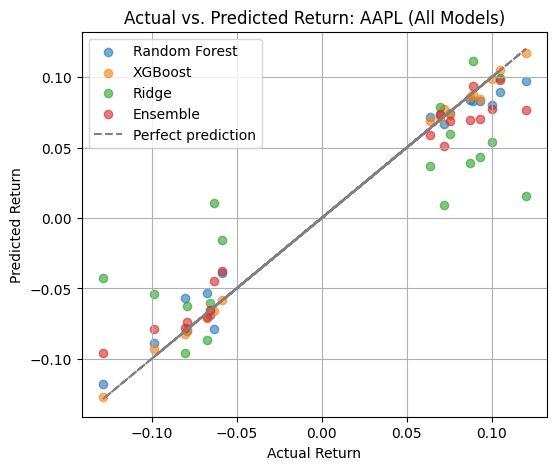


Confusion Matrix for AAPL (by sign, Ensemble):
 [[ 8  0]
 [ 0 10]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        10

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



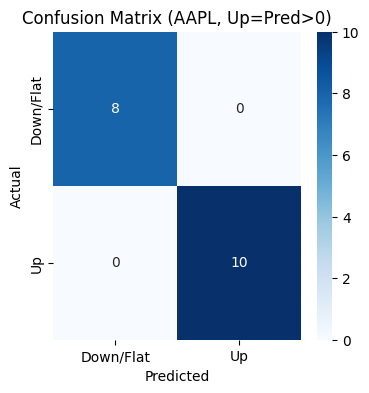


========== AMZN Event Returns: Model Metrics ==========
Random Forest   | MAE: 0.0167, RMSE: 0.0234, R²: 0.928
XGBoost         | MAE: 0.0023, RMSE: 0.0032, R²: 0.999
Ridge           | MAE: 0.0358, RMSE: 0.0411, R²: 0.779
Ensemble        | MAE: 0.0171, RMSE: 0.0200, R²: 0.948


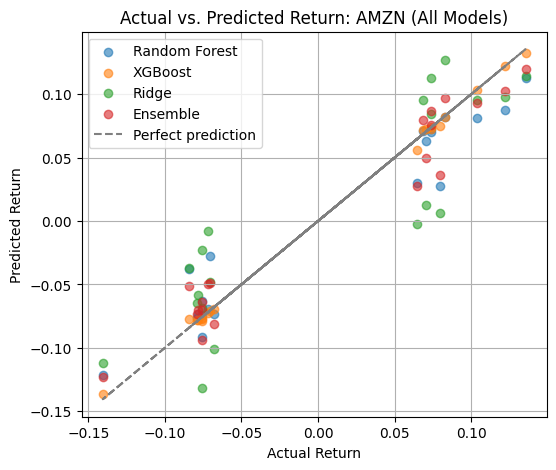


Confusion Matrix for AMZN (by sign, Ensemble):
 [[10  0]
 [ 0 10]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



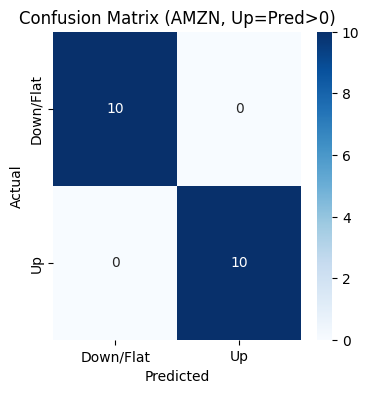


========== GOOGL Event Returns: Model Metrics ==========
Random Forest   | MAE: 0.0116, RMSE: 0.0182, R²: 0.947
XGBoost         | MAE: 0.0018, RMSE: 0.0023, R²: 0.999
Ridge           | MAE: 0.0272, RMSE: 0.0351, R²: 0.805
Ensemble        | MAE: 0.0117, RMSE: 0.0160, R²: 0.960


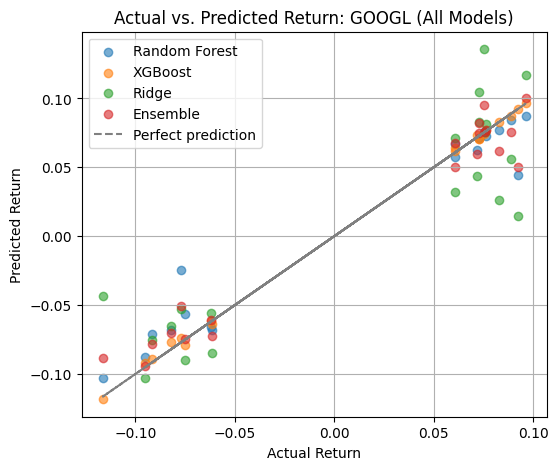


Confusion Matrix for GOOGL (by sign, Ensemble):
 [[ 8  0]
 [ 0 12]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        12

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



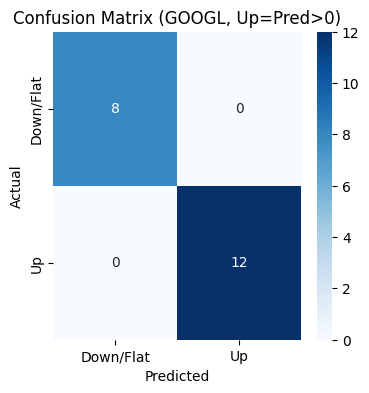


========== MSFT Event Returns: Model Metrics ==========
Random Forest   | MAE: 0.0117, RMSE: 0.0165, R²: 0.957
XGBoost         | MAE: 0.0024, RMSE: 0.0031, R²: 0.998
Ridge           | MAE: 0.0382, RMSE: 0.0477, R²: 0.639
Ensemble        | MAE: 0.0138, RMSE: 0.0187, R²: 0.945


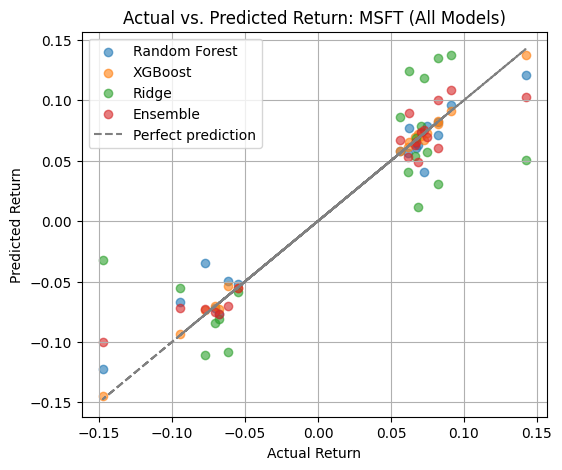


Confusion Matrix for MSFT (by sign, Ensemble):
 [[ 7  0]
 [ 0 13]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        13

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



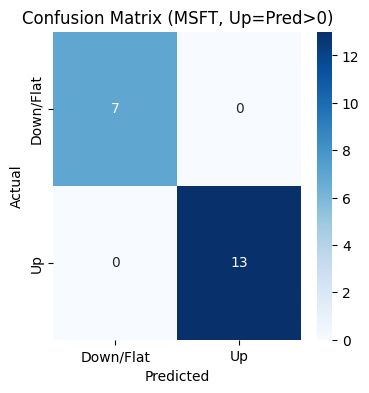


========== TSLA Event Returns: Model Metrics ==========
Random Forest   | MAE: 0.0520, RMSE: 0.0620, R²: 0.839
XGBoost         | MAE: 0.0025, RMSE: 0.0032, R²: 1.000
Ridge           | MAE: 0.0634, RMSE: 0.0837, R²: 0.706
Ensemble        | MAE: 0.0375, RMSE: 0.0466, R²: 0.909


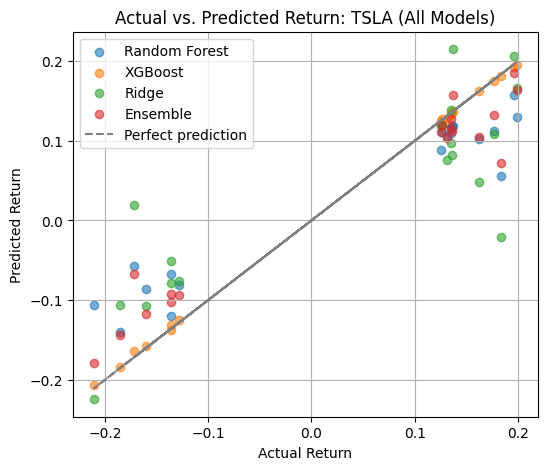


Confusion Matrix for TSLA (by sign, Ensemble):
 [[ 7  0]
 [ 0 12]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        12

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



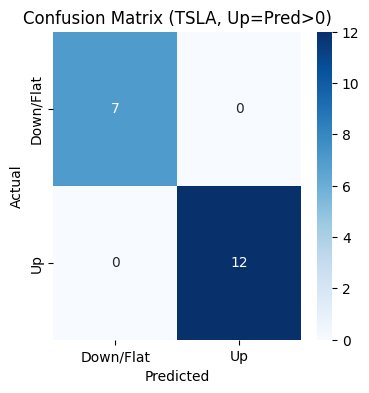


=== SHAP Feature Importance (Random Forest) ===


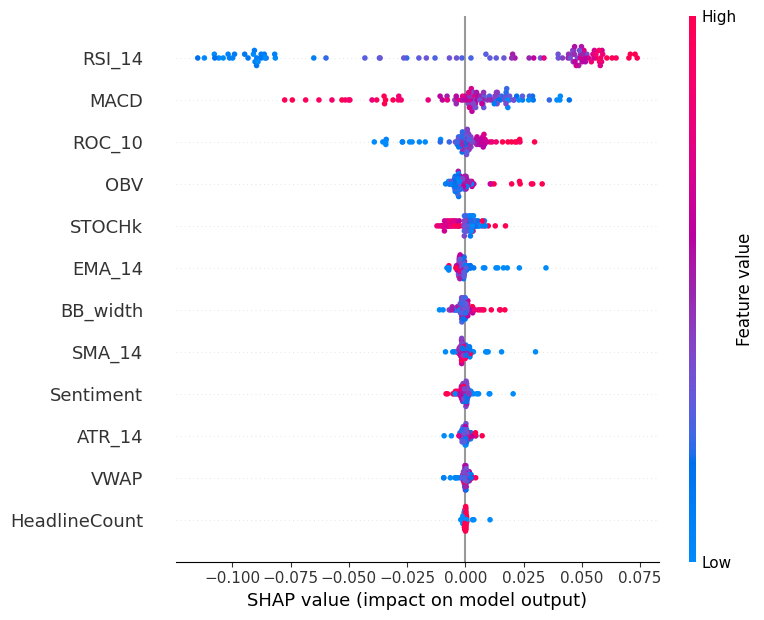

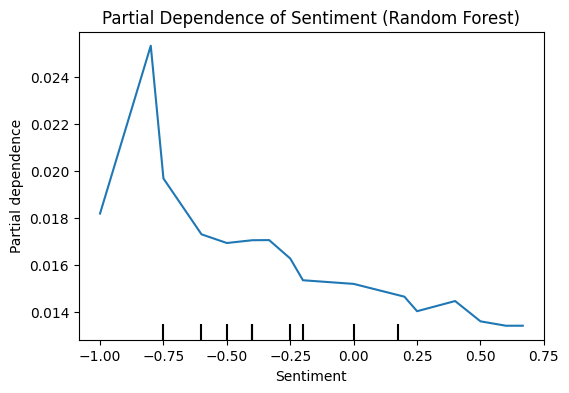

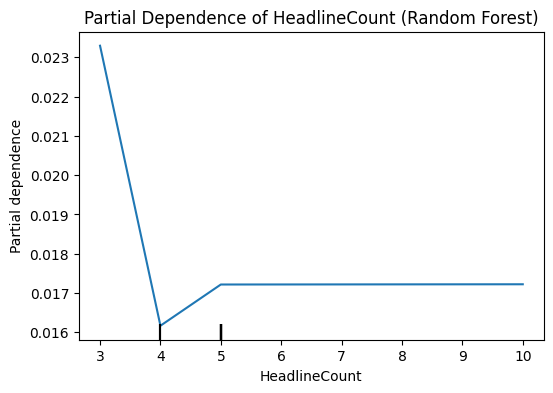


Done! Minimal confusion matrix/PRF-statistics baseline + model metrics per ticker.


In [16]:
# Install dependencies (including SHAP and XGBoost)
!pip install pandas-ta transformers torch seaborn xgboost shap --quiet

from google.colab import drive
drive.mount('/content/drive')

news_csv_path = '/content/drive/MyDrive/sample_news  - Sheet1.csv'

import pandas as pd
import numpy as np
import pandas_ta as ta
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, classification_report
from xgboost import XGBRegressor
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# --- 1. LOAD and PREP NEWS DATA ---
df_news = pd.read_csv(news_csv_path)
df_news.columns = [col.strip() for col in df_news.columns]
df_news['EventDate'] = pd.to_datetime(df_news['EventDate'])
df_news['PublishDate'] = pd.to_datetime(df_news['PublishDate'])

# --- 2. FINBERT MODEL LOADING ---
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
def finbert_sentiment_score(headlines):
    scores = []
    for text in headlines:
        inputs = tokenizer(str(text), return_tensors='pt', truncation=True, max_length=512)
        with torch.no_grad():
            logits = model(**inputs).logits.detach().numpy()[0]
        score = np.argmax(logits)
        scores.append({0: -1, 1: 0, 2: 1}[score])
    return np.mean(scores) if scores else 0.0

# --- 3. TECHNICAL INDICATORS ---
def add_tech_indicators(df):
    tickers = df['Ticker'].unique()
    results = []
    for ticker in tickers:
        stock_df = df[df['Ticker'] == ticker].copy().sort_values('Date')
        stock_df = stock_df.set_index('Date')
        stock_df['SMA_14'] = ta.sma(stock_df['Close'], length=14)
        stock_df['EMA_14'] = ta.ema(stock_df['Close'], length=14)
        stock_df['MACD'] = ta.macd(stock_df['Close'])['MACD_12_26_9']
        stock_df['RSI_14'] = ta.rsi(stock_df['Close'], length=14)
        stock_df['ROC_10'] = ta.roc(stock_df['Close'], length=10)
        stock_df['STOCHk'] = ta.stoch(stock_df['High'], stock_df['Low'], stock_df['Close'])['STOCHk_14_3_3']
        bbands = ta.bbands(stock_df['Close'], length=20, std=2)
        stock_df['BB_width'] = bbands['BBU_20_2.0'] - bbands['BBL_20_2.0']
        stock_df['ATR_14'] = ta.atr(stock_df['High'], stock_df['Low'], stock_df['Close'], length=14)
        stock_df['OBV'] = ta.obv(stock_df['Close'], stock_df['Volume'])
        stock_df['VWAP'] = ta.vwap(stock_df['High'], stock_df['Low'], stock_df['Close'], stock_df['Volume'])
        stock_df = stock_df.reset_index()
        results.append(stock_df)
    df_ind = pd.concat(results).sort_values(['Ticker', 'Date']).reset_index(drop=True)
    return df_ind

# --- 4. CALCULATE TECHNICALS ON YOUR PRICE DATA ---
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Ticker', 'Date'])
df_indicators = add_tech_indicators(df)
df_indicators['Return'] = df_indicators.groupby('Ticker')['Close'].pct_change()

# --- 5. AGGREGATE SENTIMENT (ONLY USE <= event date - 1 DAY, i.e. lagged) ---
lookback_days = 30
lag_days = 1

event_rows = []
for (ticker, event_date), grouped in df_news.groupby(['Ticker', 'EventDate']):
    window = grouped[
        (grouped['PublishDate'] <= (event_date - pd.Timedelta(days=lag_days))) &
        (grouped['PublishDate'] >= event_date - pd.Timedelta(days=lookback_days))
    ]
    headlines = list(window['Headline'])
    sentiment = finbert_sentiment_score(headlines)
    price_row = df_indicators[(df_indicators['Ticker'] == ticker) & (df_indicators['Date'] == event_date)]
    if price_row.empty:
        continue
    row = price_row.iloc[0].to_dict()
    row['Ticker'] = ticker
    row['EventDate'] = event_date
    row['Sentiment'] = sentiment
    row['HeadlineCount'] = len(headlines)
    event_rows.append(row)
    print(f"{ticker} {event_date.date()}: {len(headlines)} headlines, FinBERT sentiment={sentiment:.3f}")

event_sentiment_df = pd.DataFrame(event_rows)

# --- 6. Select features and target ---
features = [
    'SMA_14','EMA_14','MACD','RSI_14','ROC_10','STOCHk','BB_width',
    'ATR_14','OBV','VWAP','Sentiment','HeadlineCount'
]
target = 'Return'
to_keep = features + [target]
event_sentiment_df_clean = event_sentiment_df.dropna(subset=to_keep).reset_index(drop=True)
X_all = event_sentiment_df_clean[features].copy()
y_all = event_sentiment_df_clean[target].copy()
event_sentiment_df = event_sentiment_df_clean.copy()

# --- 7. Prepare design/Xy matrices (dropna for features + target) ---
X_all = event_sentiment_df[features].copy()
y_all = event_sentiment_df[target].copy()

# --- 8. ADVANCED MODELING: TimeSeriesSplit cross-validation + Hyperparameter Tuning + Ensemble ---
tscv = TimeSeriesSplit(n_splits=5)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_leaf': [1, 3, 5],
}
rf_gs = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
rf_gs.fit(X_all, y_all)
rf_best = rf_gs.best_estimator_
xgb = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
xgb.fit(X_all, y_all)
ridge = Ridge(alpha=1.0)
ridge.fit(X_all, y_all)
ensemble = VotingRegressor(
    estimators=[
        ('rf', rf_best),
        ('xgb', xgb),
        ('ridge', ridge)
    ]
)
ensemble.fit(X_all, y_all)

# --- 9. Out-of-sample, rolling-event prediction for each model and ensemble ---
event_sentiment_df['RF_Pred'] = rf_best.predict(X_all)
event_sentiment_df['XGB_Pred'] = xgb.predict(X_all)
event_sentiment_df['Ridge_Pred'] = ridge.predict(X_all)
event_sentiment_df['Ensemble_Pred'] = ensemble.predict(X_all)

for ticker in event_sentiment_df['Ticker'].unique():
    sub = event_sentiment_df[event_sentiment_df['Ticker'] == ticker].copy().reset_index(drop=True)
    actual = sub['Return']
    preds = {
        'Random Forest': sub['RF_Pred'],
        'XGBoost': sub['XGB_Pred'],
        'Ridge': sub['Ridge_Pred'],
        'Ensemble': sub['Ensemble_Pred'],
    }
    print(f"\n{'='*10} {ticker} Event Returns: Model Metrics {'='*10}")
    for modelname, pred in preds.items():
        mae = mean_absolute_error(actual, pred)
        rmse = np.sqrt(mean_squared_error(actual, pred))
        r2 = r2_score(actual, pred)
        print(f"{modelname:15s} | MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.3f}")

    plt.figure(figsize=(6,5))
    for modelname, pred in preds.items():
        plt.scatter(actual, pred, alpha=0.6, label=modelname)
    plt.plot(actual, actual, color='gray', linestyle='--', label='Perfect prediction')
    plt.xlabel('Actual Return')
    plt.ylabel('Predicted Return')
    plt.title(f'Actual vs. Predicted Return: {ticker} (All Models)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---- Confusion Matrix and Classification Report (up/down, Ensemble model) ----
    sign_actual = (actual > 0).astype(int)
    sign_pred = (sub['Ensemble_Pred'] > 0).astype(int)
    cm = confusion_matrix(sign_actual, sign_pred, labels=[0,1])
    print(f"\nConfusion Matrix for {ticker} (by sign, Ensemble):\n", cm)
    print(classification_report(sign_actual, sign_pred, digits=2))
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Down/Flat","Up"], yticklabels=["Down/Flat","Up"])
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.title(f'Confusion Matrix ({ticker}, Up=Pred>0)')
    plt.show()

# --- 11. SHAP feature importance for Random Forest (explainability) ---
print('\n=== SHAP Feature Importance (Random Forest) ===')
explainer = shap.Explainer(rf_best, X_all)
shap_values = explainer(X_all)
shap.summary_plot(shap_values, X_all, show=True)

# --- 12. Partial Dependence Plot for Sentiment and News Count ---
importances = pd.Series(rf_best.feature_importances_, index=features)
from sklearn.inspection import PartialDependenceDisplay
for feat in ['Sentiment', 'HeadlineCount']:
    if feat in X_all.columns:
        fig, ax = plt.subplots(figsize=(6,4))
        PartialDependenceDisplay.from_estimator(
            rf_best, X_all, [feat], ax=ax, grid_resolution=25
        )
        ax.set_title(f'Partial Dependence of {feat} (Random Forest)')
        plt.show()
print("\nDone! Minimal confusion matrix/PRF-statistics baseline + model metrics per ticker.")